In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[:4] = np.array([5, 1.2, -3.4, 5.6])

In [3]:
np.random.seed(0)
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)

poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] = poly_features[:, i] / math.gamma(i + 1)
labels = np.dot(poly_features, true_w.reshape(-1, 1))
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]
    

In [5]:
poly_features.shape

torch.Size([200, 20])

In [20]:
features[0]

tensor([-1.4544])

In [6]:
poly_features.numel()

4000

In [7]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        l = loss(out, y.reshape(out.shape))
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [8]:
d2l.load_array?

In [28]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    batch_size = min(10, train_features.shape[0])
    net = nn.Sequential(nn.Linear(train_features.shape[1], 1, bias=False))
    optimizer = torch.optim.SGD(net.parameters(), lr=0.03)
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size)
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    
    for epoch in range(num_epochs):
#         d2l.train_epoch_ch3(net, train_iter, loss, optimizer)
        for X, y in train_iter:
            optimizer.zero_grad()
            out = net(X)
            l = loss(out, y.reshape(out.shape))
            l.backward()
            optimizer.step()
        if epoch == 0 or epoch % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

In [29]:
true_w[:4]

tensor([ 5.0000,  1.2000, -3.4000,  5.6000])

In [30]:
# 解决matplotlib无法显示数学符号的问题：https://www.codenong.com/47253462/
import matplotlib
# Customize matplotlib
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)


In [12]:
true_w

tensor([ 5.0000,  1.2000, -3.4000,  5.6000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])

weight: [[ 5.0034986  1.2094907 -3.3987527  5.595546 ]]


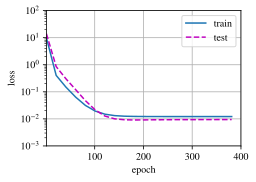

In [18]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0191388e+00  1.2452806e+00 -3.5028100e+00  5.3004646e+00
   3.0626923e-01  1.1578095e+00  3.3627349e-01  1.4894390e-01
   6.3839115e-02 -8.7696373e-02  1.7446840e-01  3.4006180e-03
  -5.8480897e-03  1.6138574e-01 -4.3796841e-02  7.4235117e-03
  -1.5579048e-01 -1.7065498e-01 -5.7953224e-02 -2.2925094e-02]]


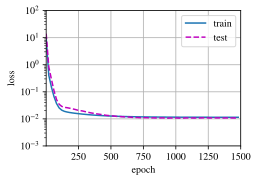

In [31]:
# 过拟合
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

weight: [[3.493046 2.960944]]


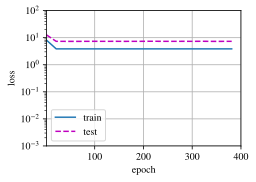

In [15]:
# 欠拟合
train(poly_features[:100, :2], poly_features[100:, :2], labels[:100], labels[100:])